<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

* Said, Rachad
* Nakache, Colin

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://competitions.codalab.org/competitions/30715

* **Étape 1 :** S'enregistrer sur https://competitions.codalab.org
* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://competitions.codalab.org/competitions/30715#participate-get_starting_kit) "Participate > Files > Public Data". Placez le dossier "public_data" dans le même dossier que celui contenant ce notebook.
* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour l'originalité et la complétude de la solution 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module particulier requis : `imblearn` (à installer avec `conda` ou `pip`)

* `conda install -c conda-forge imbalanced-learn`

* `pip install imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path
from zipfile import ZipFile
import seaborn as sns
from time import time
import imblearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
from sklearn import (
    decomposition,
    tree,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
    neighbors,
    neural_network
)

In [2]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format
begintime=time()


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<p style="color:green;">On doit créer un modèle capable de prédire si un patient hospitalisé risque de mourir en fonction de variables extraites de son dossier médical.</p>

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

<p style="color:green;"> Cette métrique prend en compte le fait que les données soient déséquilibrées (on a beaucoup moins d'exemples de personnes qui sont décédées).</p>

## 2. Chargement des données

In [3]:
DATA = Path(
    "public_dat"
).expanduser()

# DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [8]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

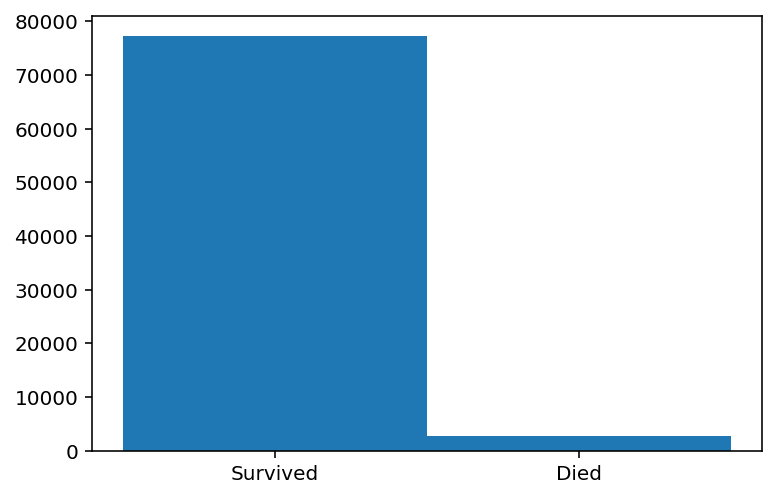

In [9]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

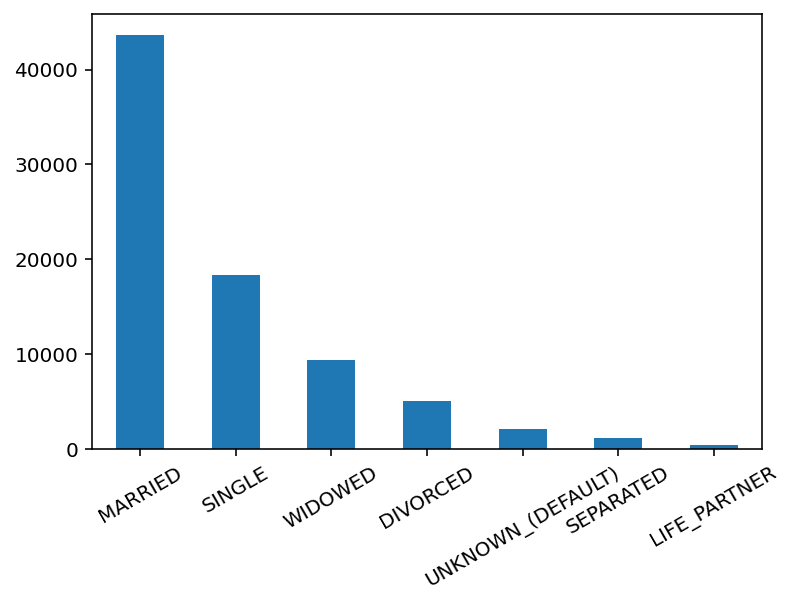

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

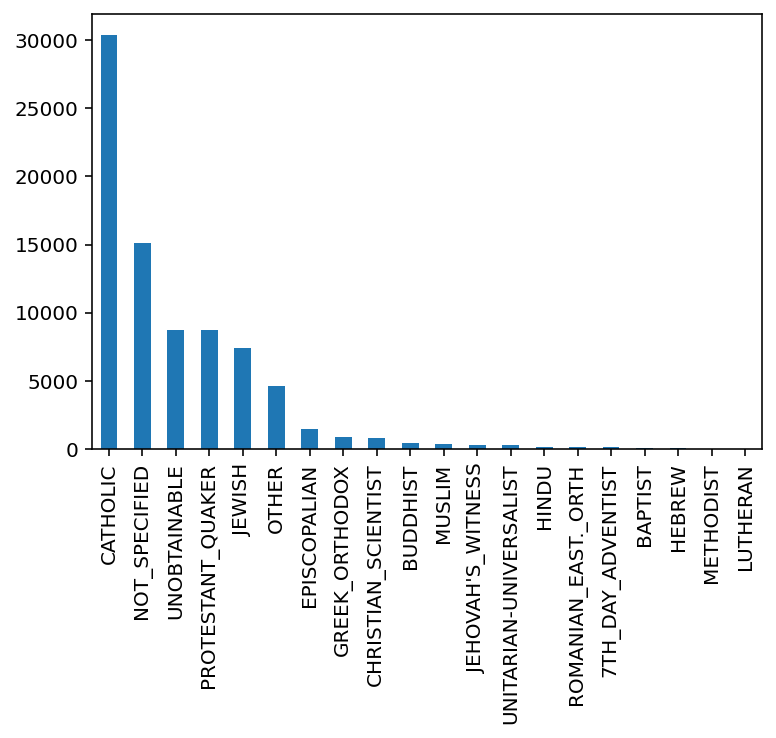

In [11]:
x_marital_cnts = x_df["RELIGION"].value_counts()
x_marital_cnts.plot.bar()
plt.show()

#### Corrélations

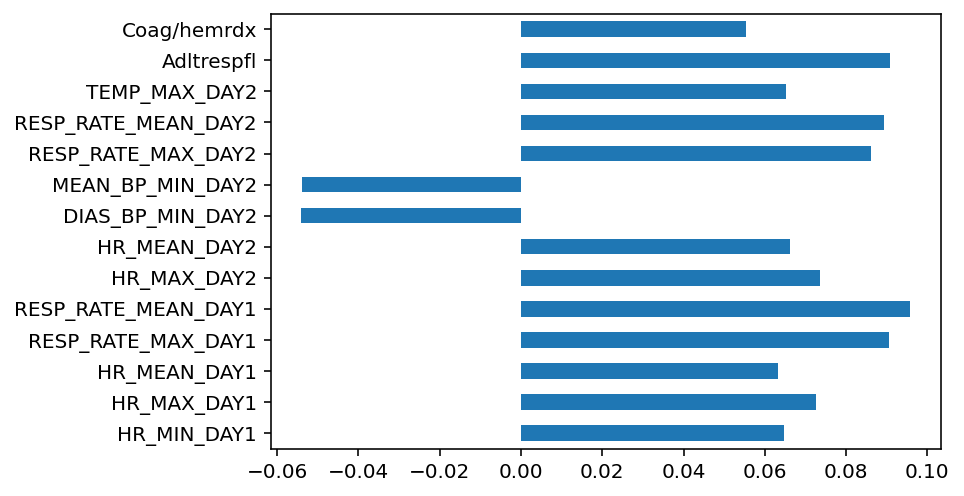

In [12]:
x_df_corr = x_df.corrwith(ys)
x_df_corr[x_df_corr.map(abs) > 0.05].plot.barh()
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<p style="color:green">Aucune des variables n'est vraiment corrélée à la variable y.</p>

#### Autres graphiques ou résultats d'une analyse exploratoire

In [13]:
d = {}
dtotal = {}

for i in range(len(ys)):
    rel = x_df["RELIGION"][i]
    c = int(ys[i] == 1)
    try:
        d[rel] += c
    except:
        d[rel] = c
    try:
        dtotal[rel] += 1
    except:
        dtotal[rel] = 1
        
for key, val in d.items():
    d[key] = val / dtotal[key]

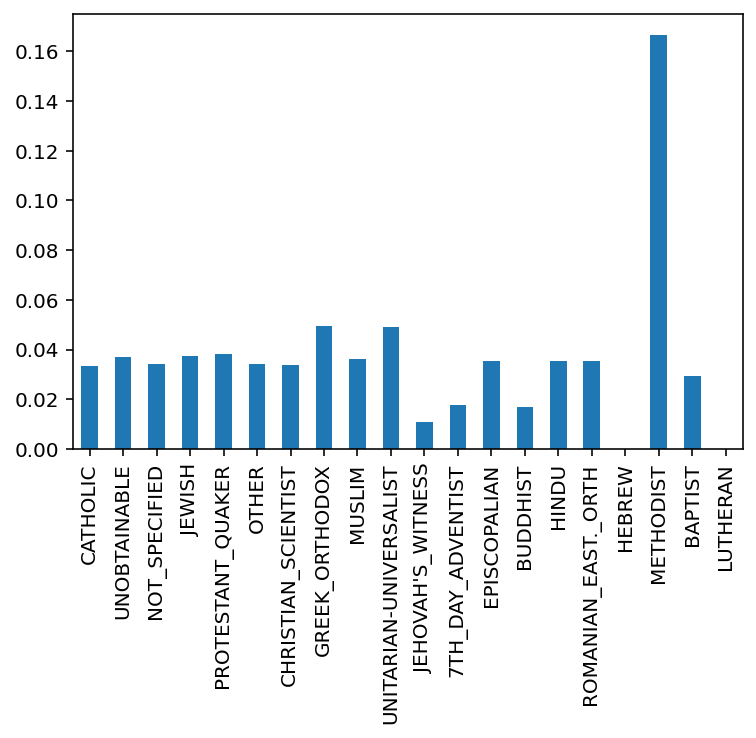

moyenne: 0.036532943032413466


In [14]:
# proportion de morts pour chaque religion
pd.Series(d).plot.bar()
plt.show()
print("moyenne:", sum(d.values()) / len(d))

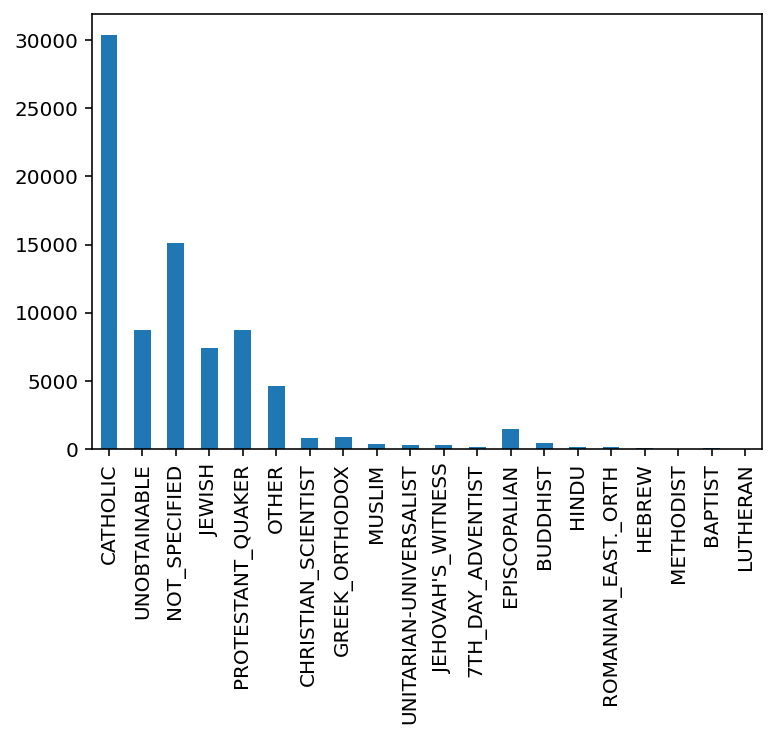

nombre de METHODIST: 6


In [15]:
# nombre d'exemples pour chaque religion
pd.Series(dtotal).plot.bar()
plt.show()
print("nombre de METHODIST:", dtotal["METHODIST"])

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

<p style="color:green">On peut voir que 16% des METHODIST sont morts dans le dataset, contre environ 3.6% pour les autres religions mais cette différence vient sûrement du faible nombre d'exemples (on a que 6 METHODIST dans le dataset).
    </p>

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [16]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [17]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [18]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [19]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,nan,0,0
9983,ENGL,MARRIED,MICU,0,nan,0
10549,ENGL,MARRIED,MICU,0,nan,0
10831,ENGL,MARRIED,MICU,nan,1,0
17012,ENGL,MARRIED,CSRU,nan,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,nan,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [20]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [21]:
print(x_df.isna().any().any(), x_test_df.isna().any().any())

False False


In [22]:
print(x_df.shape, x_test_df.shape)
x_df["MARITAL_STATUS"].value_counts()



(79999, 337) (20001, 337)


MARRIED              43662
SINGLE               18318
WIDOWED               9375
DIVORCED              5015
UNKNOWN_(DEFAULT)     2114
SEPARATED             1139
LIFE_PARTNER           376
Name: MARITAL_STATUS, dtype: int64

### Domain Expertise

Simplifiez les données en regroupant par exemple les catégories rares.

In [23]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"+"_"+col
    print(keeps)


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [24]:
# TODO: Other application of merge_rare_categories
def chkeep(dataframes,prcntg,col):
    """Fonction pour determiner le nombre  de valeurs max à considérer pour notre étude:
    Param :
        prcntg= le pourcentage des valeurs qu'on ne considère pas (0-100)
    """
    popul=dataframes[0].shape[0] # le nombre de personne qu'on étudie (80k dans notre cas)
    for e,i in enumerate(dataframes[0][col].value_counts()): # loop sur la somme de chaque variable
        if i<((prcntg*popul)/100) or e>10:
            print(i)
            return e # si i rencontre une valeur en dessous en retourne l'index ( qui est e)
def merge_rare_categories_optimized(dfs,col,prcntg):
    keep=chkeep(dfs,prcntg,col)
    merge_rare_categories(dfs, col, keeps=None, keep_n=keep)
for i in ["INSURANCE","RELIGION","LANGUAGE","ETHNICITY"]: # les variables qu'on veut regrouper (x_df[col].value_counts() pour tester)
    merge_rare_categories_optimized([x_df, x_test_df], i, 1)

Index(['Medicare', 'Private', 'Medicaid', 'Government', 'Self_Pay'], dtype='object')
773
Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH', 'OTHER', 'EPISCOPALIAN', 'GREEK_ORTHODOX'],
      dtype='object')
582
Index(['ENGL', 'SPAN'], dtype='object')
541
Index(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN', 'OTHER',
       'HISPANIC_OR_LATINO', 'ASIAN', 'UNABLE_TO_OBTAIN',
       'PATIENT_DECLINED_TO_ANSWER'],
      dtype='object')


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [25]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [26]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0


In [27]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [28]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [29]:
x_fact_df.head(5)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,2,0,2,3,0,1,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,2,0,1,3,2,0,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0


In [30]:
x_test_fact_df.head(5)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0
3,0,0,5,3,0,1,80,63.28,85.75,76.75,...,0,0,0,0,0,0,0,0,0,0
4,2,0,3,2,0,1,83,75.23,104.4,94.18,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [31]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code


{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [32]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1hot_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1hot_df = x_all_1hot_df.iloc[:len(x_df)].copy()
x_test_1hot_df = x_all_1hot_df.iloc[len(x_df):].copy()

print("(x_df),(x_test_df)=",x_df.shape, x_test_df.shape)
print("(x_1hot_df),(x_test_1hot_df)=",x_1hot_df.shape, x_test_1hot_df.shape)

(x_df),(x_test_df)= (79999, 337) (20001, 337)
(x_1hot_df),(x_test_1hot_df)= (79999, 369) (20001, 369)


#### Suppression des variables à valeur unique (constantes)

In [33]:

const_cols = {col for col in x_1hot_df if len(x_1hot_df[col].unique()) == 1}
print("const_cols=",len(const_cols))

const_cols= 173


In [34]:
print("Avant:",x_1hot_df.shape, x_test_1hot_df.shape)
x_1hot_df.drop(const_cols, axis="columns", inplace=True)
x_test_1hot_df.drop(const_cols, axis="columns", inplace=True)

print("Après:",x_1hot_df.shape, x_test_1hot_df.shape)

Avant: (79999, 369) (20001, 369)
Après: (79999, 196) (20001, 196)


### Création de l'ensemble de validation

In [35]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_1hot_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [36]:
# on réduit la différence entre nos valeurs avec StandardScaler()
scal=preprocessing.StandardScaler()
scal.fit(x_1hot_df)
# transform
x_test_1hot_scale=scal.transform(x_test_1hot_df)
x_1hot_scale=scal.transform(x_1hot_df)
x_train_scale=scal.transform(x_train)
x_valid_scale=scal.transform(x_valid)
#Affichage
print(" "*15,"x_train_scale\n\n",x_train_scale)
print("-"*50)
print(" "*15,"x_valid_scale\n\n",x_valid_scale)

                x_train_scale

 [[ 0.85   0.788 -1.168 ... -0.729  2.291 -0.396]
 [ 0.85   0.843  0.689 ...  1.371 -0.436 -0.396]
 [-1.176  0.458 -0.833 ...  1.371 -0.436 -0.396]
 ...
 [-1.176  0.788  1.225 ...  1.371 -0.436 -0.396]
 [-1.176  0.843  1.378 ... -0.729 -0.436 -0.396]
 [-1.176  0.458  0.683 ... -0.729 -0.436 -0.396]]
--------------------------------------------------
                x_valid_scale

 [[ 0.85  -1.85   2.31  ...  1.371 -0.436 -0.396]
 [ 0.85  -1.246 -1.306 ...  1.371 -0.436 -0.396]
 [-1.176 -0.806 -0.2   ...  1.371 -0.436 -0.396]
 ...
 [-1.176 -0.366 -1.357 ...  1.371 -0.436 -0.396]
 [ 0.85   0.678 -0.644 ... -0.729 -0.436 -0.396]
 [-1.176  0.513  1.744 ...  1.371 -0.436 -0.396]]


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

In [37]:
pca = decomposition.PCA(n_components=196)
#fit
pca.fit(x_1hot_scale)
#transform
x_test_1hot_pca=pca.transform(x_test_1hot_scale)
x_1hot_pca=pca.transform(x_1hot_scale)
x_train_pca=pca.transform(x_train_scale)
x_valid_pca=pca.transform(x_valid_scale)
#Affichage
print("x_train_pca =",x_train_pca.shape)
print("x_valid_pca =",x_valid_pca.shape)

x_train_pca = (55999, 196)
x_valid_pca = (24000, 196)


<span style="color:red">
    Répondre ci-dessous
</span>

Text(0, 0.5, 'Principal Component 2')

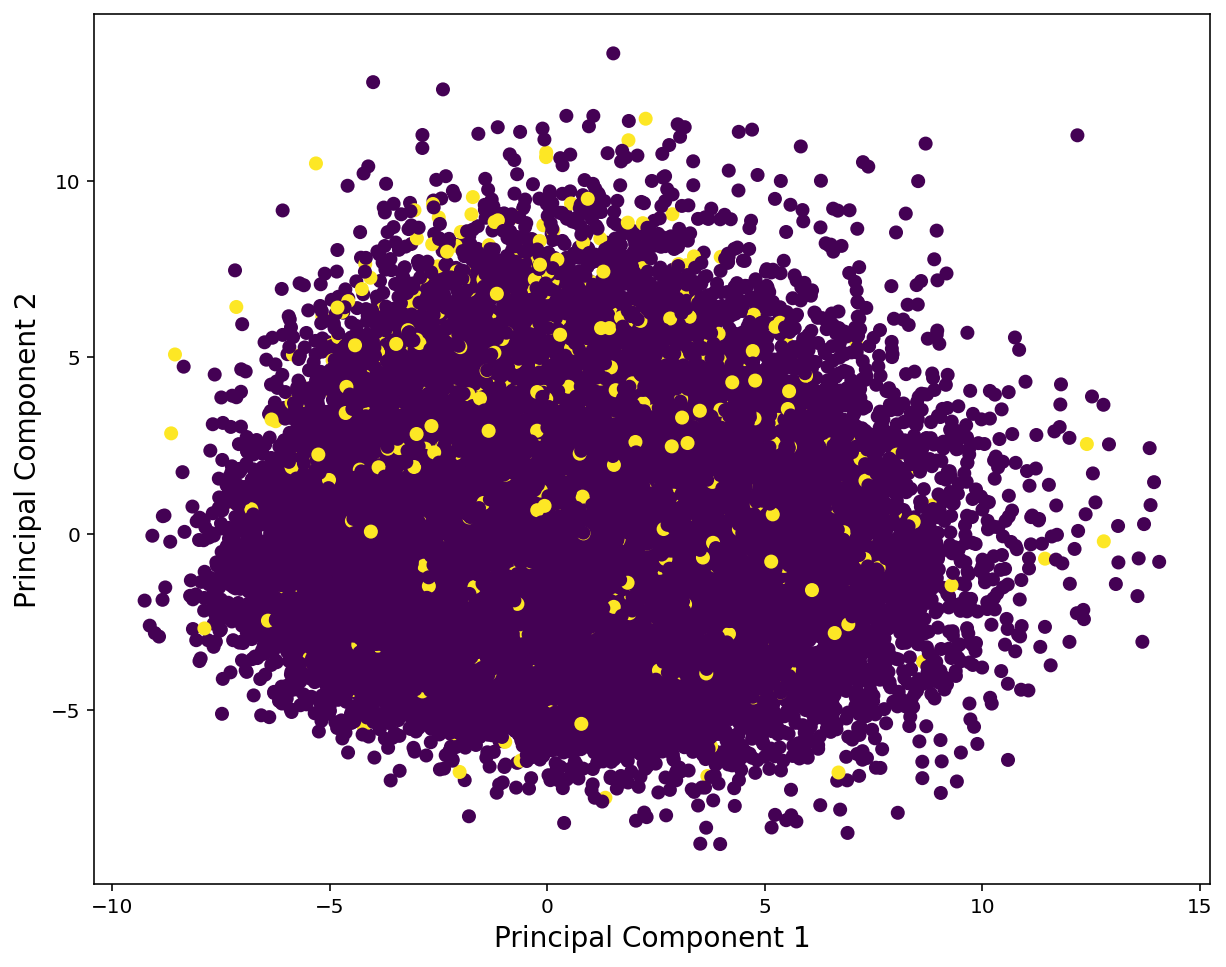

In [38]:
# TODO: Plot
COLORS = {0: "green", 1: "red", 2: "blue"}

plt.figure(figsize=(10,8))
plt.scatter(x_train_pca[:,0],x_train_pca[:,1],c=y_train)
plt.xlabel("Principal Component 1",fontsize=14)
plt.ylabel("Principal Component 2",fontsize=14)

<span style="color:green"> Deux dimensions ne suffisent pas à séparer les catégories. </span>

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [39]:
SCORINGS = "balanced_accuracy"
beg=time()
DicteOfModelTime={}



<span style="color:green">
   
</span>

In [40]:
# RandomForestClassifier
beg=time()
model_rcf = ensemble.RandomForestClassifier()
model_rcf.fit(x_train_pca, y_train) # training
DicteOfModelTime['RandomForestClassifier']=time()-beg

In [41]:
# LogisticRegression
beg=time()
model_lr = linear_model.LogisticRegression(max_iter=20000)
model_lr.fit(x_train_pca, y_train)  # training
DicteOfModelTime['LogisticRegression']=time()-beg

In [42]:
# SVM Classifier
# LogisticRegression
beg=time()
model_svc=svm.SVC(probability=True)
model_svc.fit(x_train_pca[:5000], y_train[:5000]) # training
DicteOfModelTime['SVC']=(time()-beg)*16

In [43]:
# KNeighbors Classifier
beg=time()
model_knn = neighbors.KNeighborsClassifier(n_neighbors=100)
model_knn.fit(x_train_pca, y_train)
DicteOfModelTime['KNeighborsClassifier']=(time()-beg)

In [44]:
# GaussianNB Classifier
beg=time()
model_nb = naive_bayes.GaussianNB()
model_nb.fit(x_train_pca, y_train)
DicteOfModelTime['GaussianNB']=(time()-beg)

In [45]:
# MLP Classifier
beg=time()
model_nn = neural_network.MLPClassifier(hidden_layer_sizes=(100,))
model_nn.fit(x_train_pca, y_train)
DicteOfModelTime['MLPClassifier']=(time()-beg)

In [46]:
#DiscriminantAnalysis
beg=time()
model_lda=discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
model_lda.fit(x_train,y_train)
DicteOfModelTime['LinearDiscriminantAnalysis']=(time()-beg)

## 6. Évaluations

In [47]:
# predictions avec RandomForestClassifier
y_pred_rcf = model_rcf.predict(x_valid_pca)
# scoring
score_rcf = metrics.balanced_accuracy_score(y_valid, y_pred_rcf)
print(f"Balanced accuracy score: {score_rcf:.3g}")

Balanced accuracy score: 0.5


In [48]:
# predictions avec LogisticRegression
y_pred_lr = model_lr.predict(x_valid_pca)
# scoring
score_lr = metrics.balanced_accuracy_score(y_valid, y_pred_lr)
print(f"Balanced accuracy score: {score_lr:.3g}")

Balanced accuracy score: 0.529


In [49]:
# predictions avec SVM Classifier
y_pred_svc = model_svc.predict(x_valid_pca)
# scoring
score_svc = metrics.balanced_accuracy_score(y_valid, y_pred_svc)
print(f"Balanced accuracy score: {score_svc:.3g}")

Balanced accuracy score: 0.5


In [50]:
# predictions avec KNeighbors Classifier
y_pred_knn = model_svc.predict(x_valid_pca)
# scoring
score_knn = metrics.balanced_accuracy_score(y_valid, y_pred_knn)
print(f"Balanced accuracy score: {score_knn:.3g}")

Balanced accuracy score: 0.5


In [51]:
# predictions avec GaussianNB Classifier
y_pred_nb = model_nb.predict(x_valid_pca)
# scoring
score_nb = metrics.balanced_accuracy_score(y_valid, y_pred_nb)
print(f"Balanced accuracy score: {score_nb:.3g}")

Balanced accuracy score: 0.521


In [52]:
# predictions avec MLP Classifier
y_pred_nn = model_nn.predict(x_valid_pca)
# scoring
score_nn = metrics.balanced_accuracy_score(y_valid, y_pred_nn)
print(f"Balanced accuracy score: {score_nn:.3g}")

Balanced accuracy score: 0.595


In [53]:
#predictions avec DiscriminantAnalysis
y_pred_lda = model_lda.predict(x_valid)
# scoring
score_lda = metrics.balanced_accuracy_score(y_valid, y_pred_lda)
print(f"Balanced accuracy score: {score_nn:.3g}")


Balanced accuracy score: 0.595


### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [54]:
CV = 5
SCORING = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [55]:
clf = linear_model.LogisticRegression(max_iter=20000)
model_selection.cross_val_score(clf, x_1hot_pca, ys, cv=CV, scoring=SCORING).mean()

0.5269888571115804

In [56]:
clf = naive_bayes.GaussianNB()
model_selection.cross_val_score(clf, x_1hot_pca, ys, cv=CV, scoring=SCORING).mean()

0.5222623119821961

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.



In [57]:
n_components_l = [10, 50, 100, 150, 175, 196]
res1 = []

clf = linear_model.LogisticRegression(max_iter=20000)

for n in n_components_l:
    pca = decomposition.PCA(n_components=n)
    pca.fit(x_1hot_scale)
    x_1hot_pca = pca.transform(x_1hot_scale)
    res1.append(model_selection.cross_val_score(clf, x_1hot_pca, ys, cv=CV, scoring=SCORING, n_jobs=-1))

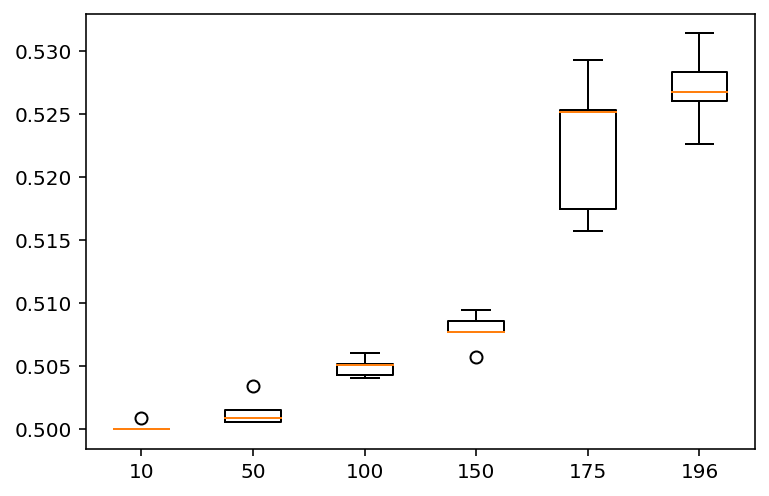

In [58]:
# balanced_accuracy en fonction du nombre de composantes de la PCA
plt.boxplot(res1, labels=n_components_l)
plt.show()

In [59]:
n_l = [60, 80, 100, 120, 140]
res2 = []

pca = decomposition.PCA(n_components=196)
pca.fit(x_1hot_scale)
x_1hot_pca = pca.transform(x_1hot_scale)

for n in n_l:
    clf = neural_network.MLPClassifier(hidden_layer_sizes=n)
    res2.append(model_selection.cross_val_score(clf, x_1hot_pca, ys, cv=CV, scoring=SCORING, n_jobs=-1))

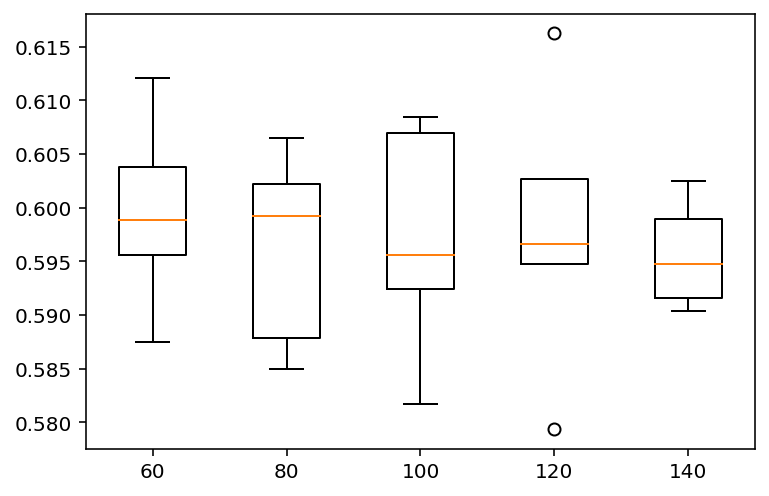

In [60]:
# balanced_accuracy en fonction de la taille de la couche cachée
plt.boxplot(res2, labels=n_l)
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Le score des prédictions semble pouvoir varier d'environ 0.03 pour ces deux modèles.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [61]:
print("roc LogisticRegression:", metrics.roc_auc_score(y_valid, model_lr.decision_function(x_valid_pca)))
print("roc MLPClassifier:", metrics.roc_auc_score(y_valid, model_nn.predict_proba(x_valid_pca)[:,1]))

roc LogisticRegression: 0.8405550384533386
roc MLPClassifier: 0.7974555797640281


<p style="color:green">Il faut un maximum de composantes avec la PCA pour LogisticRegression.
La taille de la couche cachée semble faire varier aléatoirement la précision du modèle. </p>

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

In [62]:
tn, fp, fn, tp = metrics.confusion_matrix(y_valid, y_pred_nn).ravel()
print("vrai négatif:", tn)
print("faux négatif:", fn)
print("vrai positif:", tp)
print("faux positif:", fp)


vrai négatif: 22734
faux négatif: 656
vrai positif: 174
faux positif: 436


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

<p style="color:green" >On a plus de faux négatifs que de faux positifs, or dans ce cas il faudrait que ce soir l'inverse.</p>

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [ ]:

pipe = imblearn.pipeline.Pipeline(
        [
            ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(n_components=196)),
        ("resample", imblearn.over_sampling.SMOTE()),
           
        ("model",discriminant_analysis.LinearDiscriminantAnalysis())
            
        ]
    )


pipe.fit(x_train, y_train)


y_pred_imb = pipe.predict(x_valid)
score_imb = metrics.balanced_accuracy_score(y_valid, y_pred_imb)


print("score:", score_imb)
print(metrics.classification_report(y_valid, y_pred_imb))


<p style="color:green">
On Essay d'optimiser les anciens modèle avec différence hyperparamètre pour esperer de meilleurs résultats avec GridSearchCV
On choisie nos différente Hyperparametre grâce à neighbors.KNeighborsClassifier().get_params().keys(),discriminant_analysis.LinearDiscriminantAnalysis().get_params().keys(),svm.SVC.get_params().keys()
</p>

In [64]:
discriminant_analysis.LinearDiscriminantAnalysis().get_params().keys()

dict_keys(['n_components', 'priors', 'shrinkage', 'solver', 'store_covariance', 'tol'])

In [65]:
#Pour Kneighbors
param_grid_knn={"n_neighbors":np.arange(1,100)}
grid_knn = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid_knn,cv=CV,n_jobs=-1) 
grid_knn.fit(x_train_pca[:2000],y_train[:2000]) # le programme prend une infinité de temps à séxectuer sur la range 80k , malgrès n_jobs=-1
print(grid_knn.best_score_,"with param",grid_knn.best_params_)

0.9690000000000001 with param {'n_neighbors': 2}


In [66]:
knn_predict=grid_knn.best_estimator_.predict(x_valid)
score_knn_gsc=metrics.balanced_accuracy_score(y_valid, knn_predict)
score_knn_gsc

0.5

In [67]:
#Pour LDA
param_grid_lda = {"solver" : ["svd"],"tol" : [0.0001,0.0002,0.0003]}
grid_lda=model_selection.GridSearchCV(discriminant_analysis.LinearDiscriminantAnalysis(), param_grid_lda , cv=CV,
                      n_jobs= -1, verbose = 1)
grid_lda.fit(x_train,y_train)
print(grid_lda.best_score_,"with param",grid_lda.best_params_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.9s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    7.3s finished


0.9636957843812585 with param {'solver': 'svd', 'tol': 0.0001}


In [68]:
lda_predict=grid_lda.best_estimator_.predict(x_valid)
score_lda_gsc=metrics.balanced_accuracy_score(y_valid, lda_predict)
score_lda_gsc



0.5420337370197232

<p style="color: green;">Récapitulatif des modèles utulisé + temps d'éxecution</p> 

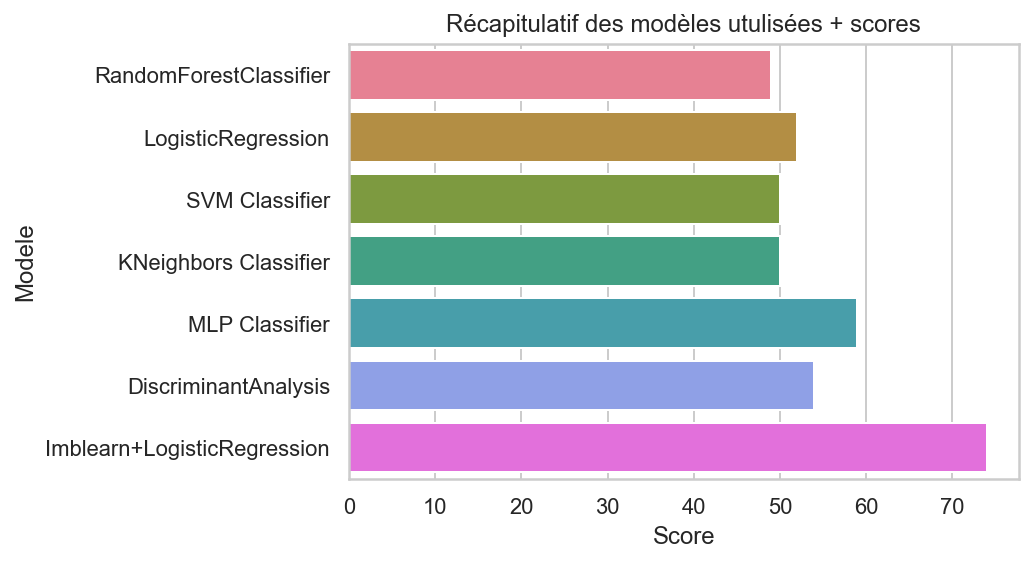

In [69]:
df = pd.DataFrame ({
        'Modele':  ['RandomForestClassifier', 'LogisticRegression', 'SVM Classifier', 'KNeighbors Classifier','MLP Classifier', 'DiscriminantAnalysis',"Imblearn+LogisticRegression"],
        'Score': [str(i*100)[:2] for i in [score_rcf,score_lr,score_svc,score_knn_gsc,score_nn,score_lda,score_imb]]
})


#ax.set_title('Récapitulatif des modèles utuliséés + scores')

sns.set_theme(style="whitegrid")
df["Score"]=df["Score"].astype(float)
ax = sns.barplot(x="Score", y="Modele", data=df,palette="husl").set_title('Récapitulatif des modèles utulisées + scores')
sns.set(rc={'figure.figsize':(11.7,10.27)})


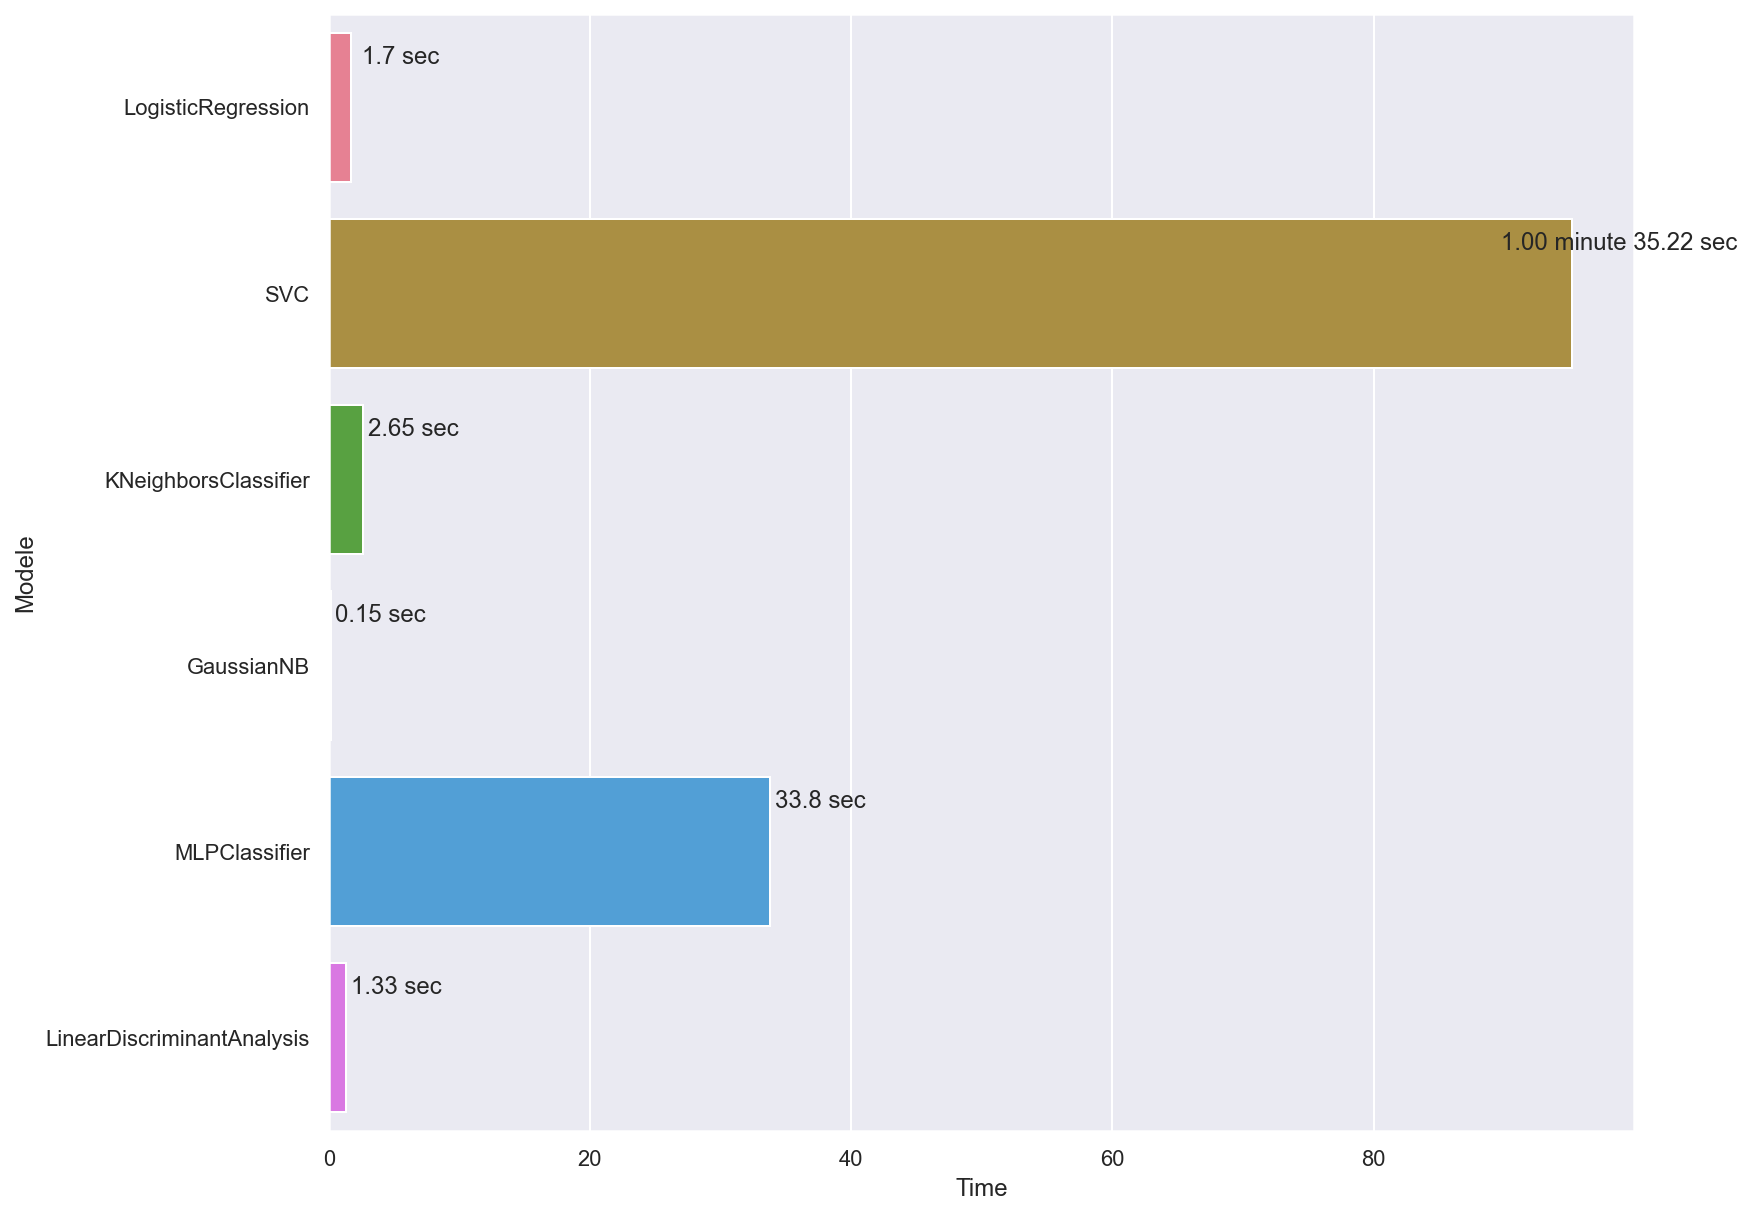

In [70]:
endtime=time()-begintime
def secondtominute(s):
    "fonction to convert second to string minute and second (float)->str"
    return str(format(divmod(s,60)[0],".2f"))+" minute " + str(format(divmod(s,60)[1],".2f" ))+" sec " if divmod(s,60)[0]!=0 else str(s) + " sec"
df=pd.DataFrame({
    "Modele":list(DicteOfModelTime)[1:],
    "Time" : list(DicteOfModelTime.values())[1:]})
ax =sns.barplot(x="Time", y="Modele", data=df,palette="husl")
for p in ax.patches:
    ax.annotate(secondtominute(float(format(p.get_width(),".2f"))), (p.get_width(),p.get_y()),
                   
                   ha = 'center', va = 'center', 
                   xytext = (25, -12), 
                   textcoords = 'offset points')

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

<p style="color:green">
- Meilleur resultat: 0.76 </br>
- On a utilisé l'encodage 1hot avec la pca pour traiter les données. On a essayé plusieurs classifiers de scikit learn (LogisticRegression, RandomForestClassifier, ...) et essayé plusieurs hyperparamètres pour augmenter le score, mais certains classifiers semblent ne pas avoir de bons scores quels que soient les hyperparamètres, comme KNeighborsClassifier. Les classifiers LogisticRegression et MLPClassifier semblaient avoir de bonnes performances sur l'ensemble de validation, et avec l'ajout de la pipeline imblearn, les performances de LogisticRegression ont encore augmenté sur l'ensemble de validation mais étaient médiocres sur l'ensemble de test. On a donc gardé le classifier Linear Discriminant pour les soumissions  </br>
- Pour choisir les hyperparamètres, on a déjà essayé de les modifier manuellement pour voir leur effet sur le score puis on a utilisé la cross validation pour essayer plus d'hyperparamètres. </br>
- Les classifiers LogisticRegression, KNeighborsClassifier et GaussianNB sont vraiment rapides à entrainer et RandomForestClassifier est un peu plus lent. Le classifier MLPClassifier est vraiment très long à entrainer mais pas autant que le classifier SVC qui est est presque inutilisable sur autant de données.Nous avons d'ailleurs crée un plot récapitulant les modèle et la durée d'éxecution </br>
-Puisque la date du rendu à été prolongé cela nous a permis de tester plus de modèle pour enfin choisir le meilleurs ,d'après une observation pragmatique on a conclus que pipeline couplé avec LinearDiscriminantAnalysis
offre la meilleurs prédictions sur les données  d'entrainement et de test </br>
Au final avec les TP et encore plus avec le projet nous avons compris et appris à manipuler des jeux de données sur des problème de la vie réel aussi des techniques de travaille ( réchantillonage,sélection d'hyperparametre,transformation et géneration de donnéees ...)
 </p> 

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ?

* En quoi pourrait-il être utile dans ce problème ? 

<p style="color:green">
   1- Le suréchantillonage ou Oversampling c'est le fait d'ajouter des données suplémentaires pour optimiser le modèle ,mal utulisé ce dernier peut mener à des cas d'overfitting</p> 
    <\br>
<p style="color:green">
 2-   on pourra l'utuliser pour ordonner nos données grâce à imblearn
 </p> 


## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_1hot_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [71]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1hot_df, ys, test_size=0.01
)




In [72]:
predictions = pipe.predict(x_test_1hot_pca) # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1hot_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions\submission_2021-05-24T21-19-12.zip


---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---